In [45]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [46]:
df = pd.read_csv('new york crime.csv')
df = df.drop_duplicates()
df = df.fillna(0)

#print(df.head())
#print(df.shape)

In [47]:
df['Population'] = df['Population'].str.replace(',','')
pop_numeric = pd.to_numeric(df['Population'])
df['PopSquared'] = pop_numeric ** 2

#print(df['PopSquared'])


In [48]:
df['IndicateMurder'] = np.where(df['Murder and\nnonnegligent\nmanslaughter'] > 0, 1, 0)
r_numeric = pd.to_numeric(df['Robbery'], errors='coerce').fillna(0)
df['IndicateRobbery'] = np.where(r_numeric > 0, 1, 0)

df['Larceny-\ntheft'] = df['Larceny-\ntheft'].str.replace(',','')
larceny_numeric = pd.to_numeric(df['Larceny-\ntheft'])
df['IndicateLarceny'] = np.where(larceny_numeric > 0, 1, 0)

df['Burglary'] = df['Burglary'].str.replace(',','')
burglary_numeric = pd.to_numeric(df['Burglary'])
df['IndicateBurglary'] = np.where(burglary_numeric > 0, 1, 0)

df['Motor\nvehicle\ntheft'] = df['Motor\nvehicle\ntheft'].str.replace(',','')
gta_numeric = pd.to_numeric(df['Motor\nvehicle\ntheft'])
df['IndicateGTA'] = np.where(gta_numeric > 0, 1, 0)

df['IndicateArson'] = df['Arson3'].astype(int)


print(df.head())

                       City Population Violent\ncrime  \
0             Adams Village       1861              0   
1  Addison Town and Village       2577              3   
2             Akron Village       2846              3   
3                    Albany      97956            791   
4            Albion Village       6388             23   

   Murder and\nnonnegligent\nmanslaughter  Rape\n(revised\ndefinition)1  \
0                                       0                           0.0   
1                                       0                           0.0   
2                                       0                           0.0   
3                                       8                           0.0   
4                                       0                           0.0   

  Rape\n(legacy\ndefinition)2 Robbery Aggravated\nassault Property\ncrime  \
0                           0       0                   0              12   
1                           0       0               

## OLS MODEL:

In [49]:
df['Property\ncrime'] = df['Property\ncrime'].str.replace(',','')
pd.to_numeric(df['Property\ncrime'])

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Property\ncrime']
X = df[['PopSquared', 'IndicateBurglary', 'IndicateLarceny', 'IndicateGTA', 'IndicateArson']]
#split the data into training set
X_train = X.iloc[:278]
Y_train = Y.iloc[:278]


regr.fit(X_train, Y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 2.00853023e-09  1.24672326e+02 -2.00368759e+01  3.19143252e+02
  7.35847914e+01]

Intercept: 
 -30.92285922399276

R-squared:
0.9893782943763039


AxesSubplot(0.125,0.125;0.62x0.755)


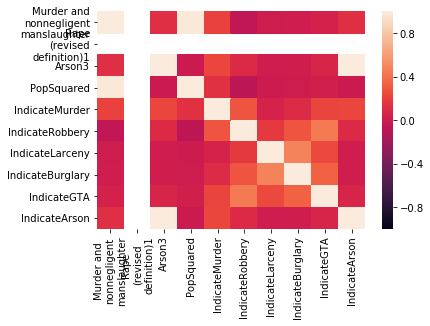

In [50]:
df_heat = sns.heatmap(df.corr(), vmin=-1, vmax=1)

print(df_heat)

In [51]:
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_train, y_train)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))

With 20% Holdout: 0.8389605022984328
Testing on Sample: 0.989412065019866


## Mean squared Error:

In [52]:
#Mean Squared Error

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The mean squared error
print("Mean squared error: " + str(mean_squared_error(y_test, y_pred)))

Mean squared error: 280323.7527790352


# KNN REGRESSION MODEL:

In [53]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X2 = df[['PopSquared', 'IndicateBurglary', 'IndicateLarceny', 'IndicateGTA', 'IndicateArson']]
Y2 = df['Property\ncrime'].astype(np.int)
X2_train = X2.iloc[:278]
Y2_train = Y2.iloc[:278]


knn.fit(X2_train, Y2_train)



KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

In [54]:
print(Y2.shape)
print(X2.shape)

(348,)
(348, 5)


In [55]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X2, Y2, cv=5)
print(score)


[0.55572838 0.68023505 0.64122587 0.03454364 0.34655852]


## Mean Squared Error

In [56]:
#Mean Squared Error

X_test2 = X2.iloc[278:]
Y_test2 = Y2.iloc[278:]

# Make predictions using the testing set
y_pred = regr.predict(X_test2)

# The mean squared error
print("Mean squared error: " + str(mean_squared_error(y_test, y_pred)))

Mean squared error: 288801949.90290356


### Generally if our data is in linear form, it will probably be better to use the OLS Linear regression model.  But if our data is in a nonlinear form, it will be better to use the KNN Regressor.


### Our data in this example does not have a linear form to it, as you can see from the scatter plot below.  Comparing our models here, using our data, it seems like picking the OLS Linear Regression model is the better choice f, because the R-squared for the OLS regression is higher, at .84 vs. the R-squared from the KNN Regressor, is only .45.  But because our data is not linear, I would pick the KNN Regressor for this example.


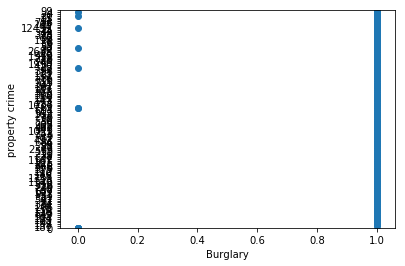

In [57]:
plt.scatter(df['IndicateBurglary'], df['Property\ncrime'])
plt.xlabel('Burglary')
plt.ylabel('property crime')
plt.ylim(Y.min(), Y.max())
plt.show()